In [37]:
import os
import math
import tqdm
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

MODELS_DIR = "C:/Users/qxem1/Computational_Intelligence/Stock Analisis/Models"
DATA_DIR = "C:/Users/qxem1/Computational_Intelligence/Stock Analisis/Data"


def next_free_model_name(base_name: str) -> str:
    model_files = [name for name in os.listdir(MODELS_DIR) if name.split(".")[-1].lower() == "h5"]
    similar_models_numbers = [int(name.split("_")[-1].split(".")[0]) for name in model_files if name.find(base_name) >= 0]
    
    if len(similar_models_numbers) > 0:
        max_value = str(max(similar_models_numbers)+1).zfill(3)
        new_name = base_name + "_" + max_value
    else:
        new_name = base_name + "_000"
    return new_name


def infinite_iterator(data: list or tuple or str) -> list or tuple or char or str:
    while True:
        for item in data:
            yield item
            

def generate_input_sequences(data: pd.DataFrame, input_length=30, output_length=1) -> np.ndarray:
    price_array = data.to_numpy()
    input_sequences = np.zeros((price_array.shape[0] - input_length - output_length,
                                input_length, price_array.shape[1]), dtype=float)
    for index in range(input_sequences.shape[0]):
        input_sequences[index] = price_array[index:index+input_length, :]
    return input_sequences


def generate_output_sequences(data: pd.DataFrame, outputs: list, input_length=30, output_length=1) -> np.ndarray:
    selected_dataframe = data[outputs]
    price_array = selected_dataframe.to_numpy()
    if output_length == 1:
        output_sequences = np.zeros((price_array.shape[0] - input_length - output_length,
                                     price_array.shape[1]), dtype=float)
        for index in range(output_sequences.shape[0]):
            output_sequences[index] = price_array[index+input_length : index+input_length+output_length, :] 
    else:
        output_sequences = np.zeros((price_array.shape[0] - input_length - output_length,
                                     output_length, price_array.shape[1]), dtype=float)
        for index in range(output_sequences.shape[0]):
            output_sequences[index] = price_array[index+input_length : index+input_length+output_length, :]
    return output_sequences

1 Physical GPUs, 1 Logical GPUs


# New York Stock Exchange Data
Dataset seleceted for project [New York Stock Exchange Data] contains large amount of data separated into 4 files.  
____
* **fundamentals.csv**  
metrics extracted from annual SEC 10K fillings (2012-2016), should be enough to derive most of popular fundamental indicators.
----
* **securities.csv**  
general description of each company with division on sectors  
----
* **prices-split-adjusted.csv**  
same as prices, but there have been added adjustments for splits.
----
* **prices.csv**  
raw, as-is daily prices. Most of data spans from 2010 to the end 2016, for companies new on stock market date range is shorter. There have been approx. 140 stock splits in that time, this set doesn't account for that.
----

[New York Stock Exchange Data]: <https://www.kaggle.com/dgawlik/nyse?select=prices.csv>

In [38]:
# Load Data
import pandas as pd

fundamentals = pd.read_csv(DATA_DIR + "/" + "fundamentals.csv", index_col=0)
securities   = pd.read_csv(DATA_DIR + "/" + "securities.csv")
prices       = pd.read_csv(DATA_DIR + "/" + "prices-split-adjusted.csv")
prices[prices["symbol"] == "MSFT"].head()

,date,symbol,open,close,low,high,volume
544,2010-01-04,MSFT,30.620001,30.950001,30.590000,31.100000,38409100.0
1012,2010-01-05,MSFT,30.850000,30.959999,30.639999,31.100000,49749600.0
1480,2010-01-06,MSFT,30.879999,30.770000,30.520000,31.080000,58182400.0
1948,2010-01-07,MSFT,30.629999,30.450001,30.190001,30.700001,50559700.0
2416,2010-01-08,MSFT,30.280001,30.660000,30.240000,30.879999,51197400.0


In [39]:
pd.set_option("display.max_columns", 80)
fundamentals[fundamentals["Ticker Symbol"] == "MSFT"]

,Ticker Symbol,Period Ending,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,Cash and Cash Equivalents,Changes in Inventories,Common Stocks,Cost of Revenue,Current Ratio,Deferred Asset Charges,Deferred Liability Charges,Depreciation,Earnings Before Interest and Tax,Earnings Before Tax,Effect of Exchange Rate,Equity Earnings/Loss Unconsolidated Subsidiary,Fixed Assets,Goodwill,Gross Margin,Gross Profit,Income Tax,Intangible Assets,Interest Expense,Inventory,Investments,Liabilities,Long-Term Debt,Long-Term Investments,Minority Interest,Misc. Stocks,Net Borrowings,Net Cash Flow,Net Cash Flow-Operating,Net Cash Flows-Financing,Net Cash Flows-Investing,Net Income,Net Income Adjustments,Net Income Applicable to Common Shareholders,Net Income-Cont. Operations,Net Receivables,Non-Recurring Items,Operating Income,Operating Margin,Other Assets,Other Current Assets,Other Current Liabilities,Other Equity,Other Financing Activities,Other Investing Activities,Other Liabilities,Other Operating Activities,Other Operating Items,Pre-Tax Margin,Pre-Tax ROE,Profit Margin,Quick Ratio,Research and Development,Retained Earnings,Sale and Purchase of Stock,"Sales, General and Admin.",Short-Term Debt / Current Portion of Long-Term Debt,Short-Term Investments,Total Assets,Total Current Assets,Total Current Liabilities,Total Equity,Total Liabilities,Total Liabilities & Equity,Total Revenue,Treasury Stock,For Year,Earnings Per Share,Estimated Shares Outstanding
1107,MSFT,2013-06-30,1.018200e+10,-1.807000e+09,288000000.0,28.0,-4.257000e+09,0.0,206.0,3.804000e+09,-802000000.0,6.730600e+10,2.038500e+10,271.0,0.0,3.469000e+09,3.755000e+09,2.705200e+10,2.705200e+10,-8000000.0,0.0,9.991000e+09,1.465500e+10,74.0,5.746400e+10,5.189000e+09,3.083000e+09,0.0,1.938000e+09,-1.780200e+10,1.841000e+09,1.260100e+10,1.084400e+10,0.0,0.0,3.537000e+09,-3.134000e+09,2.883300e+10,-8.148000e+09,-2.381100e+10,2.186300e+10,4.590000e+09,2.186300e+10,2.186300e+10,1.911800e+10,0.000000e+00,2.676400e+10,34.0,2.392000e+09,3.388000e+09,2.423600e+10,1.743000e+09,-10000000.0,-1.752000e+09,1.000000e+10,-6.070000e+08,0.0,35.0,34.0,28.0,266.0,1.041100e+10,9.895000e+09,-4.429000e+09,2.028900e+10,2.999000e+09,7.321800e+10,1.424310e+11,1.014660e+11,3.741700e+10,7.894400e+10,6.348700e+10,1.424310e+11,7.784900e+10,0.0,2013.0,2.61,8.376628e+09
1108,MSFT,2014-06-30,1.356900e+10,-1.120000e+09,61000000.0,25.0,-5.485000e+09,0.0,188.0,8.669000e+09,-161000000.0,6.836600e+10,2.707800e+10,250.0,0.0,4.736000e+09,5.212000e+09,2.782000e+10,2.782000e+10,-139000000.0,0.0,1.301100e+10,2.012700e+10,69.0,5.975500e+10,5.746000e+09,6.981000e+09,0.0,2.660000e+09,-7.324000e+09,2.562000e+09,2.064500e+10,1.459700e+10,0.0,0.0,6.962000e+09,4.865000e+09,3.250200e+10,-8.665000e+09,-1.883300e+10,2.207400e+10,4.592000e+09,2.207400e+10,2.207400e+10,2.148500e+10,1.270000e+08,2.775900e+10,32.0,3.422000e+09,4.392000e+09,3.005600e+10,3.708000e+09,-39000000.0,-6.024000e+09,1.159400e+10,-6.570000e+08,0.0,32.0,31.0,25.0,245.0,1.138100e+10,1.771000e+10,-6.709000e+09,2.048800e+10,2.000000e+09,7.704000e+10,1.723840e+11,1.142460e+11,4.562500e+10,8.978400e+10,8.260000e+10,1.723840e+11,8.683300e+10,0.0,2014.0,2.66,8.298496e+09
1109,MSFT,2015-06-30,1.238500e+10,1.456000e+09,346000000.0,15.0,-5.944000e+09,0.0,194.0,5.595000e+09,-272000000.0,6.846500e+10,3.303800e+10,247.0,0.0,3.390000e+09,5.957000e+09,1.850700e+10,1.850700e+10,-73000000.0,0.0,1.473100e+10,1.693900e+10,65.0,6.054200e+10,6.314000e+09,4.835000e+09,0.0,2.902000e+09,-1.286800e+10,-7.900000e+07,2.780800e+10,1.205300e+10,0.0,0.0,1.366100e+10,-3.074000e+09,2.966800e+10,-9.668000e+09,-2.300100e+10,1.219300e+10,1.000500e+10,1.219300e+10,1.219300e+10,1.790800e+10,1.001100e+10,1.816100e+10,19.0,3.117000e+09,5.461000e+09,2.977800e+10,2.522000e+09,362000000.0,-4.189000e+09,1.354400e+10,4.080000e+08,0.0,20.0,23.0,13.0,241.0,1.204600e+10,9.096000e+09,-1.380900e+10,2.032400e+10,7.484000e+09,9.093100e+10,1.744720

In [40]:
securities[securities["Ticker symbol"] == "MSFT"].head()

,Ticker symbol,Security,SEC filings,GICS Sector,GICS Sub Industry,Address of Headquarters,Date first added,CIK
306,MSFT,Microsoft Corp.,reports,Information Technology,Systems Software,"Redmond, Washington",1994-06-01,789019


# Selected stock indicators
____
* __On-Balance Volume__ *(OBV)*  
Indicator of stock momentum based on close price and stock volume
____
* __Accumulation/Distribution Index__ *(ADI)*  
money flow indicator considers stock volume as well as closing price in regard to price range.
____
* __Aroon Indicator__ *(AI / AIU / AID)*  
Trend following indicator, describes strength of the current trend and likely hood that it will continue.  
May be divided into up and down indexes.
____
* __Relative Strength Index__ *(RSI)*  
Measurement of the of price change magnitude, indicates overbought or oversold conditions in the price of a stock.
____
* __Volume Weighted Average Price__ *(VWAP)*
Average price calculated in regard to stock volume.
____
* __Simple Moving Average 7 Days__ *(SMA7)*  
Moving average over 7 day period
____
* __Simple Moving Average 14 Days__ *(SMA14)*  
Moving average over 14 day period
____

In [41]:
import ta
import numpy as np
import matplotlib.pyplot as plt

ticker = "MSFT"
stock_price = prices[prices["symbol"] == ticker]
plt.rcParams["figure.figsize"] = (16,3)

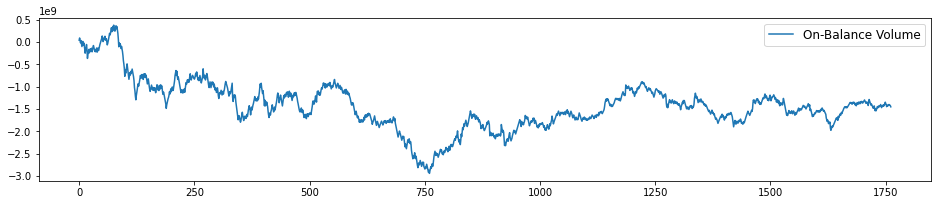

In [42]:
OBV = ta.volume.on_balance_volume(stock_price["close"], stock_price["volume"])
plt.plot(np.arange(len(OBV)), OBV, label="On-Balance Volume")
plt.legend(fontsize="large")
plt.show()

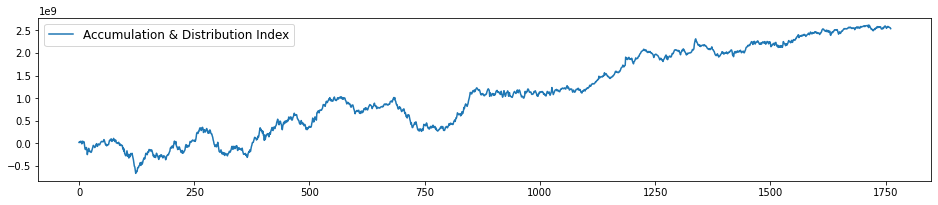

In [43]:
indicator = ta.volume.AccDistIndexIndicator(stock_price["high"], stock_price["low"],
                                            stock_price["close"], stock_price["volume"])
ADI = indicator.acc_dist_index()
plt.plot(np.arange(len(ADI)), ADI, label="Accumulation & Distribution Index")
plt.legend(fontsize="large")
plt.show()

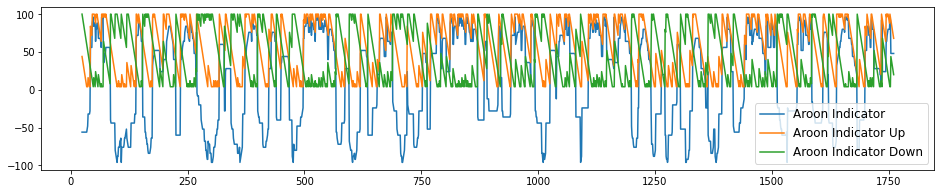

In [44]:
indicator = ta.trend.AroonIndicator(stock_price["close"])
AI  = indicator.aroon_indicator()
AIU = indicator.aroon_up()
AID = indicator.aroon_down()
plt.plot(np.arange(len(AI)), AI, label="Aroon Indicator")
plt.plot(np.arange(len(AIU)), AIU, label="Aroon Indicator Up")
plt.plot(np.arange(len(AID)), AID, label="Aroon Indicator Down")
plt.legend(fontsize="large")
plt.show()

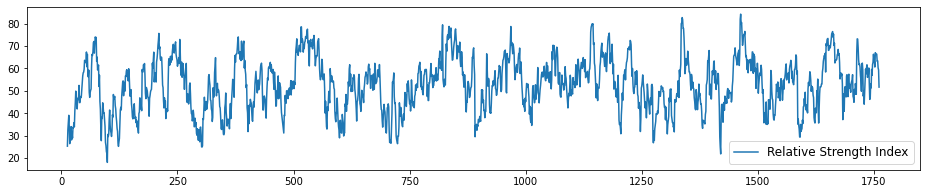

In [45]:
indicator = ta.momentum.RSIIndicator(close=stock_price["close"], window=14)
RSI = indicator.rsi()
plt.plot(np.arange(len(RSI)), RSI, label="Relative Strength Index")
plt.legend(fontsize="large")
plt.show()

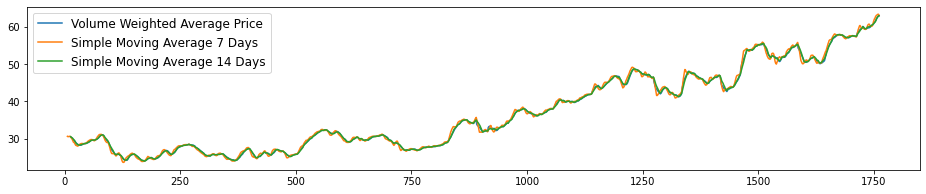

In [46]:
indicator = ta.volume.VolumeWeightedAveragePrice(stock_price["high"], stock_price["low"], 
                                     stock_price["close"],stock_price["volume"], window=14)
VWAP = indicator.volume_weighted_average_price()

indicator = ta.trend.SMAIndicator(stock_price["close"], window=7)
SMA7 = indicator.sma_indicator()

indicator = ta.trend.SMAIndicator(stock_price["close"], window=14)
SMA14 = indicator.sma_indicator()

plt.plot(np.arange(len(VWAP)), VWAP, label="Volume Weighted Average Price")
plt.plot(np.arange(len(SMA7)), SMA7, label="Simple Moving Average 7 Days")
plt.plot(np.arange(len(SMA14)), SMA14, label="Simple Moving Average 14 Days")
plt.legend(fontsize="large")
plt.show()

In [47]:
indicators = pd.DataFrame()
indicators["OBV"] = OBV
indicators["ADI"] = ADI
indicators["AI"] = AI
indicators["AID"] = AID
indicators["VWAP"] = VWAP
# indicators["SMA7"] = SMA7
# indicators["SMA14"] = SMA14
indicators["close"] = stock_price["close"]

indicators = indicators.dropna()
indicators.head()

,OBV,ADI,AI,AID,VWAP,close
11776,-217647100.0,-1.845589e+08,-56.0,100.0,28.918897,27.719999
12244,-158451300.0,-1.915822e+08,-56.0,96.0,28.792828,28.010000
12712,-207042600.0,-2.037300e+08,-56.0,92.0,28.665757,27.990000
13180,-141048900.0,-1.905311e+08,-56.0,88.0,28.567642,28.120001
13648,-222166100.0,-1.533522e+08,-56.0,84.0,28.470470,27.930000


In [48]:
from sklearn.preprocessing import MinMaxScaler
transformer = MaxAbsScaler().fit(indicators)
scaled_indicators = pd.DataFrame(transformer.transform(indicators), columns=indicators.columns)
print(scaled_indicators.shape)
scaled_indicators.head()

(1738, 6)


,OBV,ADI,AI,AID,VWAP,close
0,0.821259,0.147287,0.208333,1.000000,0.127246,0.115981
1,0.839087,0.145149,0.208333,0.958333,0.124011,0.123122
2,0.824453,0.141451,0.208333,0.916667,0.120751,0.122630
3,0.844328,0.145469,0.208333,0.875000,0.118234,0.125831
4,0.819898,0.156788,0.208333,0.833333,0.115741,0.121152


In [53]:
sequence_length = 14
predicted_values = ["close"]

train_data_length = (0, round(0.7 * scaled_indicators.shape[0]))
val_data_length = (round(0.7 * scaled_indicators.shape[0])+1, round(0.9 * scaled_indicators.shape[0]))
test_data_length = (round(0.9 * scaled_indicators.shape[0])+1, scaled_indicators.shape[0])

train_x = generate_input_sequences(data=scaled_indicators[train_data_length[0]:train_data_length[1]],
                                   input_length=sequence_length)
train_y = generate_output_sequences(data=scaled_indicators[train_data_length[0]:train_data_length[1]],
                                    input_length=sequence_length, outputs=predicted_values)

val_x = generate_input_sequences(data=scaled_indicators[val_data_length[0]:val_data_length[1]],
                                 input_length=sequence_length)
val_y = generate_output_sequences(data=scaled_indicators[val_data_length[0]:val_data_length[1]],
                                  input_length=sequence_length, outputs=predicted_values)

test_x = generate_input_sequences(data=scaled_indicators[test_data_length[0]:test_data_length[1]],
                                  input_length=sequence_length)
test_y = generate_output_sequences(data=scaled_indicators[test_data_length[0]:test_data_length[1]],
                                   input_length=sequence_length, outputs=predicted_values)

print(f"Train_x: {train_x.shape}")
print(f"Train_y: {train_y.shape}")
print("---------------------------------")
print(f"Val_x:   {val_x.shape}")
print(f"Val_y:   {val_y.shape}")
print("---------------------------------")
print(f"Test_x:  {test_x.shape}")
print(f"Test_y:  {test_y.shape}")

Train_x: (1202, 14, 6)
Train_y: (1202, 1)
---------------------------------
Val_x:   (331, 14, 6)
Val_y:   (331, 1)
---------------------------------
Test_x:  (158, 14, 6)
Test_y:  (158, 1)


In [56]:
epochs = 100
batch_size = 32

In [57]:
import keras
from keras import models
from keras import layers
from keras import metrics

model_name = "First Model"

model = models.Sequential(name=model_name)

model.add(layers.LSTM(units=50, activation="relu", name="LSTM_1", dropout=0.05, 
                      input_shape=(train_x.shape[1], train_x.shape[2]), 
                      return_sequences=True))

model.add(layers.LSTM(units=100, activation="relu", name="LSTM_2", dropout=0.1))

model.add(layers.Dense(units=200, activation="relu", name="Dense_1"))
model.add(layers.Dropout(0.15, name="Dropout_1"))

model.add(layers.Dense(units=400, activation="relu", name="Dense_2"))
model.add(layers.Dropout(0.25, name="Dropout_2"))

model.add(layers.Dense(units=50, activation="relu", name="Dense_3"))

model.add(layers.Dense(1, activation="tanh", name="classifier"))

model.compile(optimizer="Adam", 
              loss="mae", 
              metrics=["mean_absolute_percentage_error"])
model.summary()

history =  model.fit(train_x, train_y,
                     epochs=epochs,
                     batch_size=batch_size, 
                     validation_data=(val_x, val_y))


Model: "First Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM_1 (LSTM)                (None, 14, 50)            11400     
_________________________________________________________________
LSTM_2 (LSTM)                (None, 100)               60400     
_________________________________________________________________
Dense_1 (Dense)              (None, 200)               20200     
_________________________________________________________________
Dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
Dense_2 (Dense)              (None, 400)               80400     
_________________________________________________________________
Dropout_2 (Dropout)          (None, 400)               0         
_________________________________________________________________
Dense_3 (Dense)              (None, 50)                

1202/1202 [==============================] - 2s 1ms/step - loss: 0.0215 - mean_absolute_percentage_error: 24651.9043 - val_loss: 0.0882 - val_mean_absolute_percentage_error: 13.5498
Epoch 36/100
1202/1202 [==============================] - 2s 1ms/step - loss: 0.0198 - mean_absolute_percentage_error: 37547.6523 - val_loss: 0.0570 - val_mean_absolute_percentage_error: 8.5754
Epoch 37/100
1202/1202 [==============================] - 2s 1ms/step - loss: 0.0204 - mean_absolute_percentage_error: 37021.2539 - val_loss: 0.1014 - val_mean_absolute_percentage_error: 15.8388
Epoch 38/100
1202/1202 [==============================] - 2s 2ms/step - loss: 0.0198 - mean_absolute_percentage_error: 33407.3320 - val_loss: 0.0901 - val_mean_absolute_percentage_error: 13.7801
Epoch 39/100
1202/1202 [==============================] - 2s 1ms/step - loss: 0.0192 - mean_absolute_percentage_error: 31020.0469 - val_loss: 0.0845 - val_mean_absolute_percentage_error: 12.9230
Epoch 40/100
1202/1202 [===============

1202/1202 [==============================] - 2s 2ms/step - loss: 0.0157 - mean_absolute_percentage_error: 25140.8145 - val_loss: 0.0624 - val_mean_absolute_percentage_error: 9.3933
Epoch 78/100
1202/1202 [==============================] - 2s 1ms/step - loss: 0.0194 - mean_absolute_percentage_error: 20297.6445 - val_loss: 0.0905 - val_mean_absolute_percentage_error: 13.9332
Epoch 79/100
1202/1202 [==============================] - 2s 1ms/step - loss: 0.0179 - mean_absolute_percentage_error: 26639.3770 - val_loss: 0.0795 - val_mean_absolute_percentage_error: 12.1753
Epoch 80/100
1202/1202 [==============================] - 2s 1ms/step - loss: 0.0169 - mean_absolute_percentage_error: 26442.9531 - val_loss: 0.0815 - val_mean_absolute_percentage_error: 12.3886
Epoch 81/100
1202/1202 [==============================] - 2s 2ms/step - loss: 0.0178 - mean_absolute_percentage_error: 25980.3535 - val_loss: 0.0621 - val_mean_absolute_percentage_error: 9.2200
Epoch 82/100
1202/1202 [================

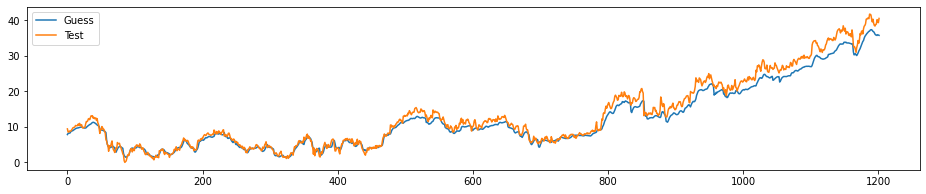

In [61]:
from sklearn.preprocessing import MaxAbsScaler

predictions = model.predict(train_x)

scaler = MaxAbsScaler().fit(indicators["close"].to_numpy().reshape(-1,1))
unscaled_predictions = scaler.inverse_transform(predictions)
unscaled_test_data = scaler.inverse_transform(train_y)
plt.plot(np.arange(len(predictions)), unscaled_predictions, label="Guess")
plt.plot(np.arange(len(predictions)), unscaled_test_data, label="Test")
plt.legend()
plt.show()